## MNIST に関するスパース信号再現

DU-ISTA法によるスパース信号再現

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [4]:
using LinearAlgebra
using Flux
using MLDatasets
using Plots
gr()
using Flux.Data: DataLoader
using Flux: onehotbatch
using Tullio

### グローバル変数の設定

In [5]:
K = 50

n = 784
m = 512
num_itr = 25
adam_lr = 5e-5
max_inner = 50

A = randn(m, n)
γ_opt = 1.0/maximum(eigvals(A'*A)) 

0.0003898099256692554

### MNIST画像を表示 (ミニバッチの先頭16個を表示)

In [6]:
function show_img(x)
    x = reshape(x, 28, 28, K)
    p = []
    for k in 1:16
        tmp = x[:,:,k]
        @tullio img[i,j] := tmp[j,28-i+1]
        append!(p,[heatmap(img, c=:bone, legend=false, xticks=false, yticks=false)])
    end
    plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],
        p[8],p[9],p[10],p[11],p[12],p[13],p[14],p[15],p[16],layout=(4,4))
end

show_img (generic function with 1 method)

### データローダを準備

In [7]:
xtrain, _ = MLDatasets.MNIST.traindata(Float32)
xtest, _ = MLDatasets.MNIST.testdata(Float32)
train_loader = DataLoader(xtrain, batchsize=K, shuffle=true)
test_loader = DataLoader(xtest, batchsize=K);

### ミニバッチ生成関数

In [8]:
function mini_batch(K)
    x_org,_ = iterate(train_loader)
    x = reshape(x_org, 784, K)
    y = A*x
    return x,y
end    

function test_mini_batch(K)
    x_org,_ = iterate(test_loader)
    x = reshape(x_org, 784, K)
    y = A*x
    return x,y
end    

test_mini_batch (generic function with 1 method)

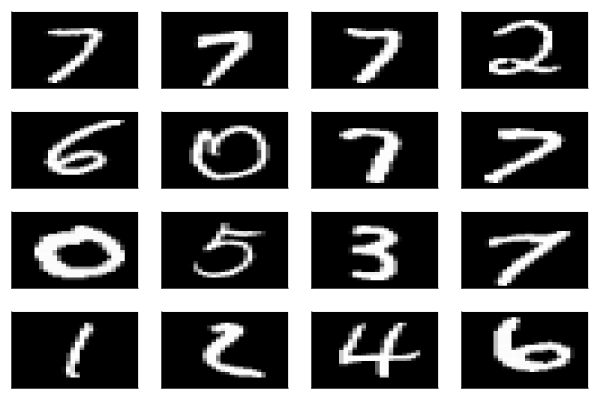

In [9]:
x,_ = mini_batch(K)
show_img(x)

### ISTAによる再現実験

In [10]:
S(x,τ) = sign(x)*max(abs(x)-τ,0)

function ISTA(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - γ_opt*A'*(A*x - y)
        x = S.(x, γ_opt)
    end
    return x
end

ISTA (generic function with 1 method)

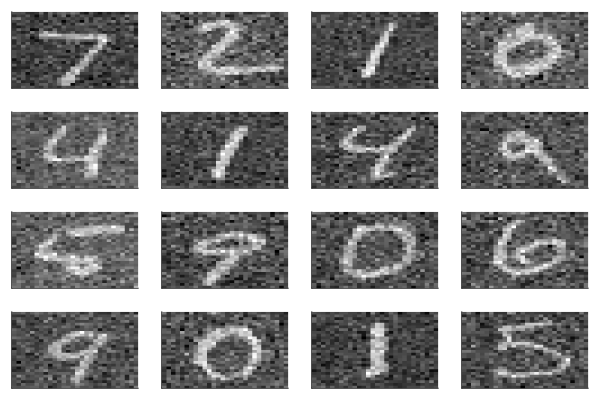

In [11]:
x_test, y_test = test_mini_batch(K)
x_hat = ISTA(num_itr, y_test);
p1 = show_img(x_hat)

### DU-ISTA法の反復

In [12]:
function DU_ISTA(max_itr, y, γ, α)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - γ[i]*A'*(A*x - y)
        x = S.(x, α[i])
    end
    return x
end

DU_ISTA (generic function with 1 method)

In [13]:
function loss(x, y)
    return norm(x - y)^2/K
end  

loss (generic function with 1 method)

### 学習プロセス

In [14]:
function train(opt, γ, α)
    ps = Flux.params(γ, α) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            x,y = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_ISTA(itr, y, γ, α)
                loss(x, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        x, y = test_mini_batch(K)
        x_hat = DU_ISTA(itr, y, γ, α)
        println(itr, " ", loss(x, x_hat))
    end
end

train (generic function with 1 method)

In [ ]:
γ_train = γ_opt*ones(num_itr)
α_train = γ_opt*ones(num_itr)
opt = Flux.ADAM(adam_lr)
train(opt, γ_train, α_train)

1 44.96638197553206
2 34.532842433322685
3 29.521223033892273
4 26.699339309998294
5 24.078399162773817
6 21.362101870719783
7 19.22955986756333
8 17.29359407850532
9 15.571928787490089
10 13.956192250155135
11 12.38873534338595
12 10.997422914162396
13 9.750866720028487
14 8.447348041946233
15 7.269003491372526
16 6.327701152325631


### DU-ISTAによる再現実験

In [ ]:
x_hat = DU_ISTA(num_itr, y_test, γ_train, α_train);
p2 = show_img(x_hat)

In [ ]:
plot(p1,p2)

In [ ]:
savefig("MNIST-reconstruction.pdf")